# Import relevant libraries

In [1]:
import matplotlib.pyplot as plt   
import seaborn as sns; sns.set()  
import numpy as np  
import pandas as pd 
from sklearn.cluster import KMeans 
from datetime import datetime, timedelta

## Reading function

In [2]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [3]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [5]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-06-30 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [6]:
# coordinates of city center as [lat, lng]
br_center = [53.078893247451994, 8.8027747491885]
du_center = [51.226815497281706, 6.773786392066722]

In [7]:
from haversine import haversine, Unit

dataBr["distance_from_center_start"] = dataBr.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataBr["distance_from_center_end"] = dataBr.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_start"] = dataDu.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_end"] = dataDu.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 

## Data for Clustering

In [8]:
# set time window for the given data
dat_time_framed_br = dataBr.loc[(dataBr["datetime_start"] >= startDate) & (dataBr["datetime_start"] <= endDate)]
dat_time_framed_du = dataDu.loc[(dataDu["datetime_start"] >= startDate) & (dataDu["datetime_start"] <= endDate)]

### Dropping redundant/unnecessary features and normalizing

With the clustering approach we want to find hidden relationships in the data set, that we might or might not have seen or hypothesized about beforehand.

Obviously, if we throw in the whole data set to be clustered, there could be some strong correlations internal to the data which are overshadowing other, true (hidden) relation ships.

For this purpose, some redundant columns that might overlap and some that are unspecific to the data (e.g. fleetsize) are dropped to maintain a better clustering quality.

#### Drop columns

In [9]:
X = dat_time_framed_br.drop(["Unnamed: 0","b_number","day","time","trip_duration","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly","weekday","month","week","rounded_time_hourly"], axis=1);
Y = dat_time_framed_du.drop(["Unnamed: 0","b_number","day","time","trip_duration","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly","weekday","month","week","rounded_time_hourly"], axis=1);

#### Convert to numeric types

In [10]:
# convert dates to seconds
X["datetime_start"] = pd.to_numeric(X["datetime_start"])
X["datetime_end"] = pd.to_numeric(X["datetime_end"])

Y["datetime_start"] = pd.to_numeric(Y["datetime_start"])
Y["datetime_end"] = pd.to_numeric(Y["datetime_end"])

In [11]:
X.info()
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57894 entries, 0 to 57893
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   orig_lat                    57894 non-null  float64
 1   orig_lng                    57894 non-null  float64
 2   dest_lat                    57894 non-null  float64
 3   dest_lng                    57894 non-null  float64
 4   datetime_start              57894 non-null  int64  
 5   datetime_end                57894 non-null  int64  
 6   hour                        57894 non-null  int64  
 7   distance                    57894 non-null  float64
 8   trip_duration_hours         57894 non-null  float64
 9   avg_speed                   57894 non-null  float64
 10  temp                        57894 non-null  float64
 11  wind                        57894 non-null  float64
 12  rain                        57894 non-null  float64
 13  distance_from_center_start  578

## Create some plots to get an intuition of what clusters might be found

#### Bremen

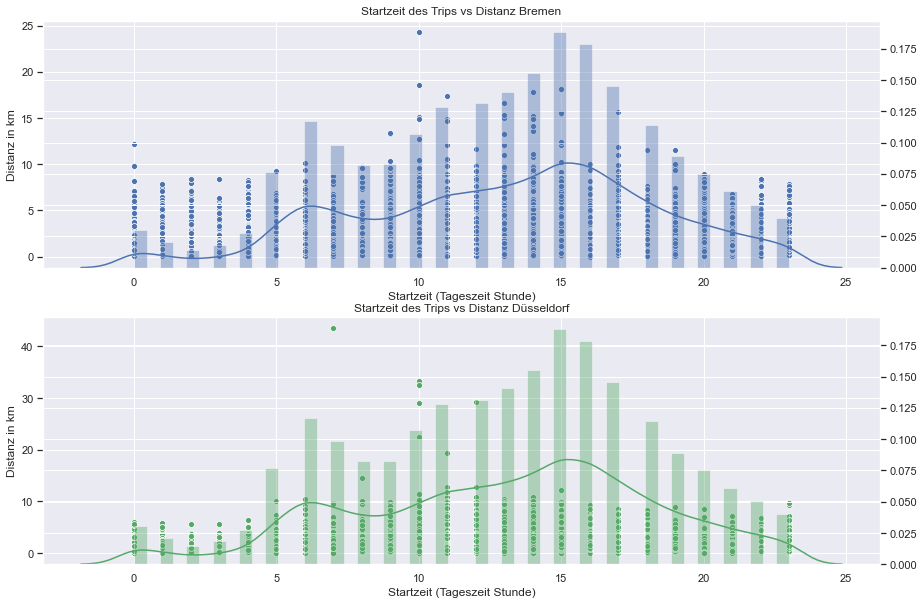

In [12]:
# create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.scatterplot(ax = ax1, data=X, x="hour", y="distance", ci=None);
axtwin1 = ax1.twinx()
sns.distplot(X["hour"], ax = axtwin1)
ax1.set_title('Startzeit des Trips vs Distanz Bremen')  
ax1.set_xlabel('Startzeit (Tageszeit Stunde)');
ax1.set_ylabel('Distanz in km');

sns.scatterplot(ax = ax2, data=Y, x="hour", y="distance", color = 'g', ci=None);
axtwin2 = ax2.twinx()
sns.distplot(X["hour"], ax = axtwin2, color='g')
ax2.set_title('Startzeit des Trips vs Distanz Düsseldorf')  
ax2.set_xlabel('Startzeit (Tageszeit Stunde)');
ax2.set_ylabel('Distanz in km');

##### there seems to be an obvious tendency for trips to happen at rush/peak hours (06:00/07:00, 15:00/16:00) but here we also see, that in both cities the longes trips happen during early midday (10:00, 11:00)

(0.0, 16.0)

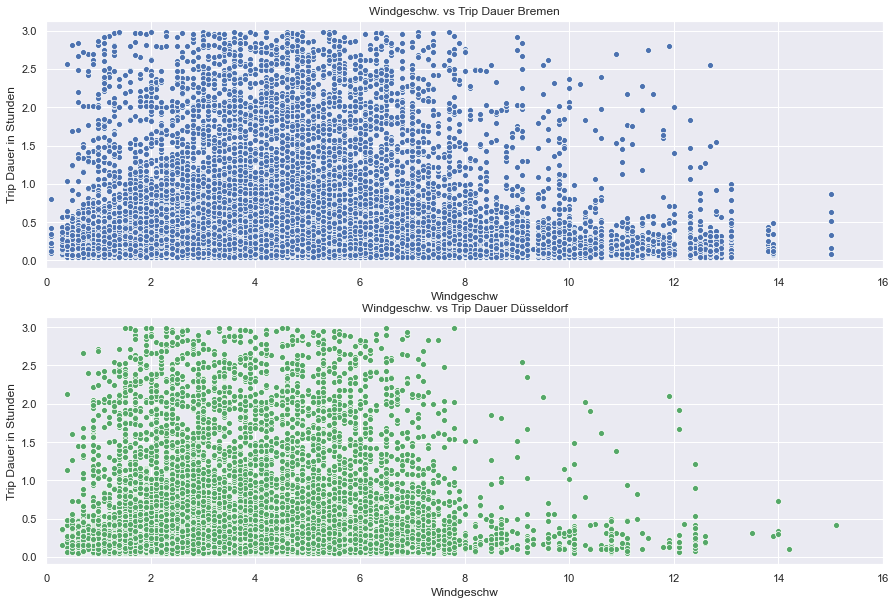

In [13]:
# create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.scatterplot(ax = ax1, data=X, x="wind", y="trip_duration_hours", ci=None);  
ax1.set_title('Windgeschw. vs Trip Dauer Bremen')  
ax1.set_xlabel('Windgeschw');
ax1.set_ylabel('Trip Dauer in Stunden');
ax1.set_xlim(0, X["wind"].max()+1)

sns.scatterplot(ax = ax2, data=Y, x="wind", y="trip_duration_hours", color='g', ci=None);  
ax2.set_title('Windgeschw. vs Trip Dauer Düsseldorf')  
ax2.set_xlabel('Windgeschw');
ax2.set_ylabel('Trip Dauer in Stunden');
ax2.set_xlim(0, X["wind"].max()+1)

##### wind has a very clear impact on the trip duration as well as the total number of trips: when the wind is strong, there are fewer and shorter trips. However, the negative impact of wind seems to be stronger for Düsseldorf

## Clustering 

#### Normalize

In [14]:
from sklearn.preprocessing import StandardScaler

def norm(df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)

    # create a df out of array
    df_scaled_df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled, df_scaled_df
    

X_norm, X_norm_df = norm(X)
Y_norm, Y_norm_df = norm(Y)

X_norm_df.head()

,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,hour,distance,trip_duration_hours,avg_speed,temp,wind,rain,distance_from_center_start,distance_from_center_end
0,0.052755,2.309151,0.040096,2.753492,-0.220670,-0.220780,0.770594,-0.512654,-0.275384,-0.645520,0.904379,-1.211424,-0.140957,1.793378,2.256311
1,0.052755,2.309151,-0.003631,1.971327,0.552909,0.552681,0.389097,-0.839654,-0.517670,-0.621686,0.947427,-1.023798,-0.140957,1.793378,1.460179
2,0.052755,2.309151,-0.206180,1.943354,1.093163,1.092942,1.724334,-0.690467,-0.477289,-0.354698,0.789584,-0.085668,-0.140957,1.793378,1.442564
3,-0.210255,2.000564,0.053206,2.245269,1.129015,1.130712,-0.564643,-0.690467,4.126139,-1.828968,1.076571,-0.742359,-0.140957,1.491707,1.738655
4,0.052755,2.309151,-0.113083,2.462562,1.131961,1.134011,-0.183147,-0.859359,4.974139,-1.871447,1.105270,-0.085668,-0.140957,1.793378,1.963879


### Find optimal k value

#### with normalized values

In [15]:
def find_k(norm_values):
    k_max = 10

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1)
        model.fit(norm_values)
        clusters.append(k+1)
        losses.append(model.inertia_)
    
    return clusters, losses

In [16]:
clustersBr_norm, lossesBr_norm = find_k(X_norm)
clustersDu_norm, lossesDu_norm = find_k(Y_norm)

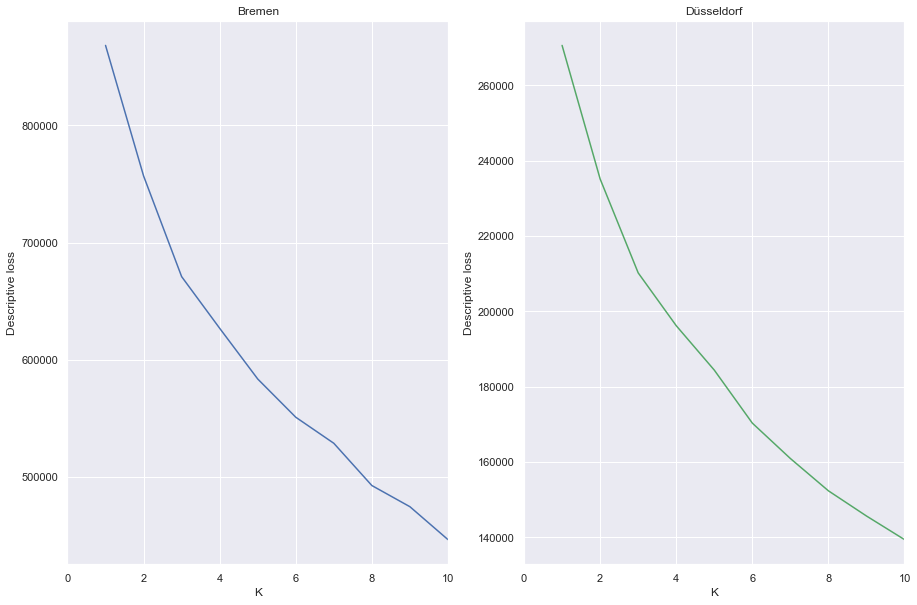

In [17]:
def plot_losses(lim, clus1, loss1, clus2, loss2):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax1.plot(clus1, loss1)
    ax2.plot(clus2, loss2, color='g')

    ax1.set_title("Bremen")
    ax1.set_ylabel("Descriptive loss")
    ax1.set_xlabel("K")
    ax1.set_xlim(lim)

    ax2.set_title("Düsseldorf")
    ax2.set_ylabel("Descriptive loss")
    ax2.set_xlabel("K")
    ax2.set_xlim(lim)
    plt.show()

plot_losses([0,10], clustersBr_norm, lossesBr_norm, clustersDu_norm, lossesDu_norm)

It seems as if a good value could be between 2 and 7

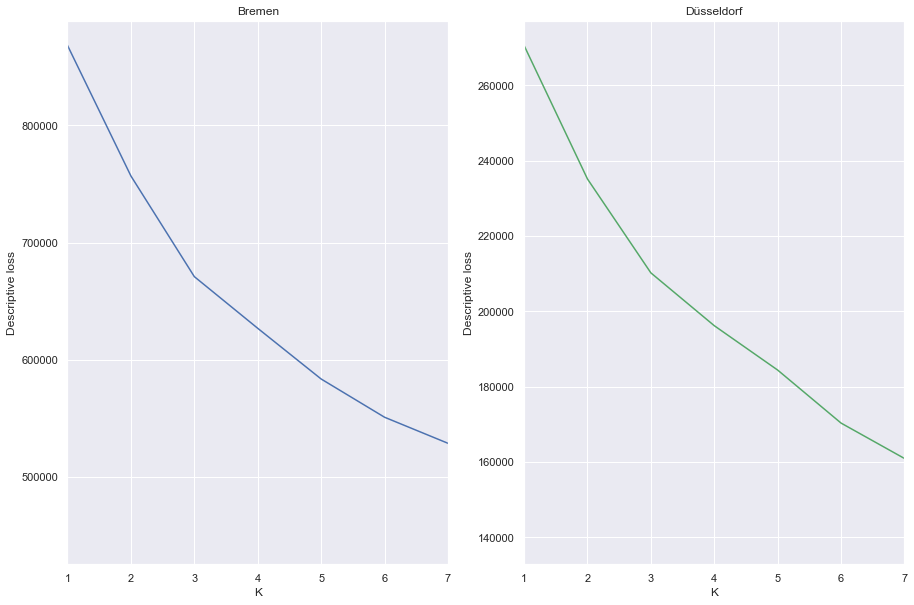

In [18]:
plot_losses([1,7], clustersBr_norm, lossesBr_norm, clustersDu_norm, lossesDu_norm)

##### with normalized values, we see that k=3 might be a good option

#### with unprocessed values

In [19]:
clustersBr, lossesBr = find_k(X)
clustersDu, lossesDu = find_k(Y)

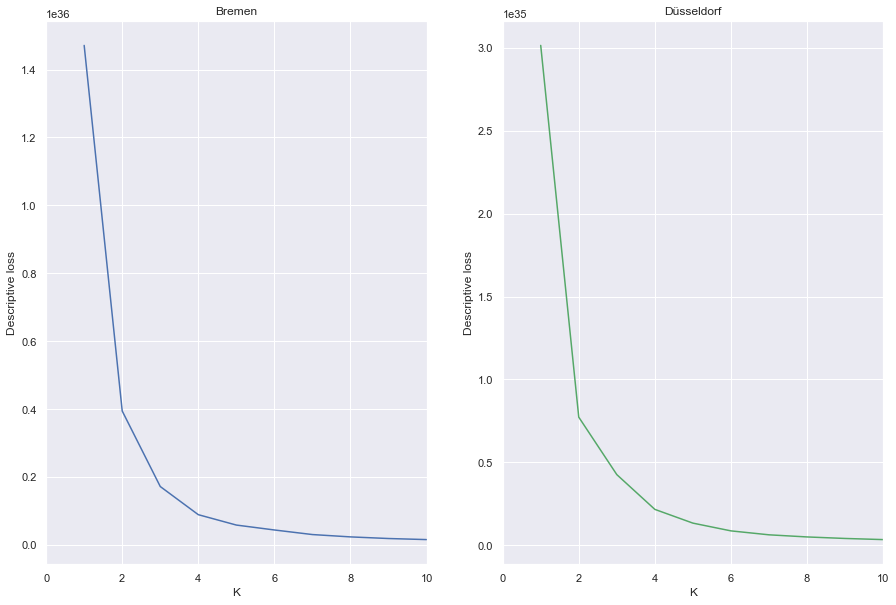

In [20]:
plot_losses([0,10], clustersBr, lossesBr, clustersDu, lossesDu)

##### without normalization we see, that k=3 is indeed a good choice

### Generate clusters with k=3 and normalized values

In [21]:
kmeans = KMeans(n_clusters=3)
km_x = kmeans.fit_predict(X_norm_df)
km_y = kmeans.fit_predict(Y_norm_df)

In [22]:
def get_counts(city, datX, datY, clus_x, clus_y):
    dat = X if city == "Bremen" else Y
    clus_label = km_x if city == "Bremen" else km_y
    
    for i in range(0,3):
        print(f"{city} cluster {i+1}: ", dat[clus_label==i].count()[1])

In [23]:
get_counts("Bremen", X, Y, km_x, km_y)
get_counts("Düsseldorf", X, Y, km_x, km_y)

Bremen cluster 1:  28210
Bremen cluster 2:  23640
Bremen cluster 3:  6044
Düsseldorf cluster 1:  5416
Düsseldorf cluster 2:  10578
Düsseldorf cluster 3:  2044


##### cluster 2 in düsseldorf has a very low amount of cases

#### Plotting all 3 clusters in a single figure, 2 selected columns

In [24]:
def plot_clusters_city(city, col1, col2, datX, datY, clus_x, clus_y):
    dat = datX if city == "Bremen" else datY
    clus_label = clus_x if city == "Bremen" else clus_y
        
    plt.scatter(
       dat[clus_label==0][col1], dat[clus_label==0][col2],
        s=30, c='lightgreen',
        marker='s', edgecolor='black',
        label='cluster 1'
    )

    plt.scatter(
       dat[clus_label==1][col1], dat[clus_label==1][col2],
       s=30, c='orange',
        marker='o', edgecolor='black',
        label='cluster 2'
    )


    plt.scatter(
       dat[clus_label==2][col1], dat[clus_label==2][col2],
        s=30, c='lightblue',
        marker='v', edgecolor='black',
        label='cluster 3'
    )
    plt.title(city)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    plt.show()

##### plotting the starting hour of trip (1), rain values (2), wind values (3) and temp values (4) vs driven distance, respectively

##### starting hour

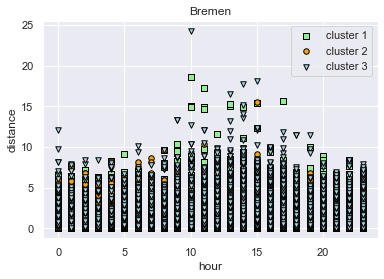

In [25]:
plot_clusters_city("Bremen", "hour", "distance", X, Y, km_x, km_y)

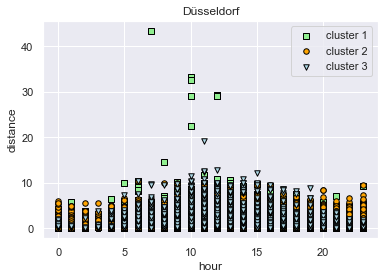

In [26]:
plot_clusters_city("Düsseldorf", "hour", "distance", X, Y, km_x, km_y)

--> no significant differences across clussters in both cities

##### rain

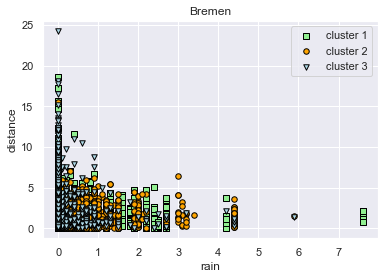

In [27]:
plot_clusters_city("Bremen", "rain", "distance", X, Y, km_x, km_y)

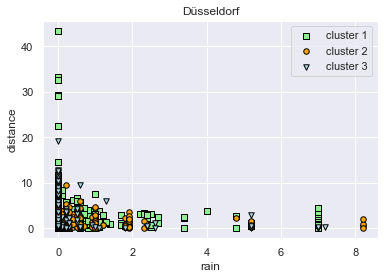

In [28]:
plot_clusters_city("Düsseldorf", "rain", "distance", X, Y, km_x, km_y)

--> cluster 1 and 2from Bremen and cluster 1 and 3 from düsseldorf contain more trips with heavier rain compared to the other clusters

##### wind

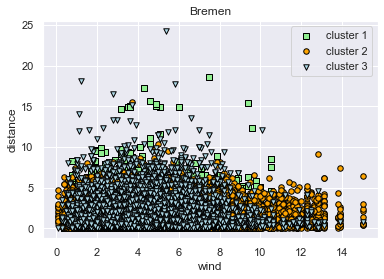

In [29]:
plot_clusters_city("Bremen", "wind", "distance", X, Y, km_x, km_y)

- Cluster 1 and 3 contain those trips with comparably higher driven distance
- values from cluster 2 contain largely a similar maximum driven distance of about 6-7 kilometers
- cluster 2 contains a wide spectrum of wind values, suggesting that these customers did not care about wind

##### Hypothesis: since cluster 2 contains those trips with customers who do not care about wind as much as rain but drive on average the same maximum distance, it could contain the commuting trips (assuming the impact of wind on the decision to drive with either the bike or the car is lower than the impact of rain)

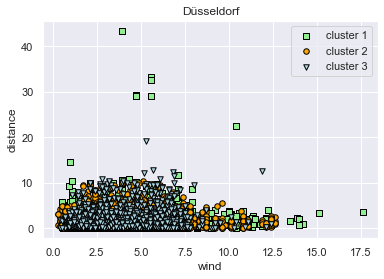

In [30]:
plot_clusters_city("Düsseldorf", "wind", "distance", X, Y, km_x, km_y)

##### cluster 2 and 3 from Düsseldorf look similar to the clusters 1 and 3 from Bremen

##### temp

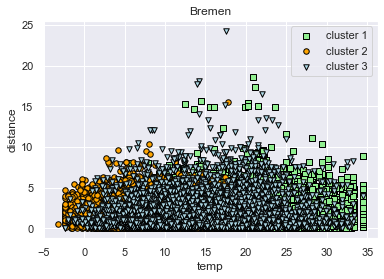

In [31]:
plot_clusters_city("Bremen", "temp", "distance", X, Y, km_x, km_y)

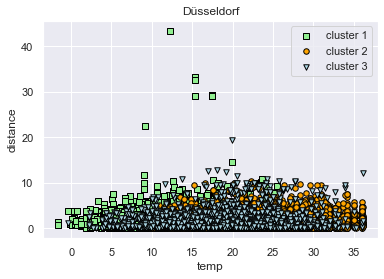

In [33]:
plot_clusters_city("Düsseldorf", "temp", "distance", X, Y, km_x, km_y)

##### temperature differences seem to be interesting across clusters, now plotting the temperature across clusters with a different second criterion, i.e. trip duration in hours

In [34]:
def plot_clusters_temps(city):
    dat = X if city == "Bremen" else Y
    clus_label = km_x if city == "Bremen" else km_y

    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    ax.scatter(
        dat[clus_label == 0]["temp"], dat[clus_label == 0]["trip_duration_hours"],
        s=50, c='lightgreen',
        marker='s', edgecolor='black',
        label='cluster 1'
    )

    ax.scatter(
        dat[clus_label == 1]["temp"], dat[clus_label == 1]["trip_duration_hours"],
        s=50, c='orange',
        marker='o', edgecolor='black',
        label='cluster 2'
    )

    ax.scatter(
        dat[clus_label == 2]["temp"], dat[clus_label == 2]["trip_duration_hours"],
        s=50, c='lightblue',
        marker='v', edgecolor='black',
        label='cluster 3'
    )

    plt.xlabel("Temperatur")
    plt.ylabel("Trip duration in Stunden")
    plt.legend()
    print("Min 1, 2, 3: ", dat[clus_label == 0]["temp"].min(), dat[clus_label == 1]["temp"].min(), dat[clus_label == 2]["temp"].min())
    print("Max 1, 2, 3: ", dat[clus_label == 0]["temp"].max(), dat[clus_label == 1]["temp"].max(), dat[clus_label == 2]["temp"].max())

Min 1, 2, 3:  2.8 -3.2 -2.4
Max 1, 2, 3:  34.4 19.9 34.4


C:\Users\andre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


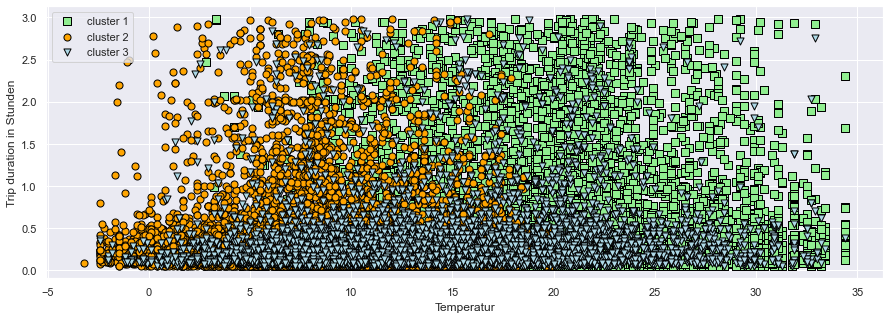

In [35]:
plot_clusters_temps("Bremen")

##### One cluster (cluster 2) differs significantly from the others in that it has a much lower maximum temperature (~20°C)

This seems to align with the fact, that in this cluster there are on average much more varying wind values. It could be that this cluster is a cluster of commuting trips, since these are happening at lower temperatures (however, with more varying weather)

If one would argue that cluster 2 contains trips as free time activities, it would be questionable since the temperatures do not exceed 20°C which is unusual for bike trips in the free time

Min 1, 2, 3:  -1.6 8.7 -0.4
Max 1, 2, 3:  25.9 36.1 36.1


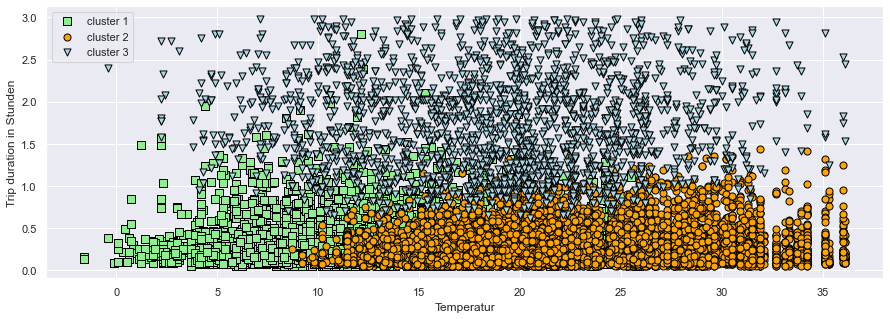

In [36]:
plot_clusters_temps("Düsseldorf")

##### here we see similar for Düsseldorf, but the cluster labels are mixed up. 
- cluster 3(bremen) = cluster 2(düsseldorf)
- cluster 2(bremen) = cluster 1(düsseldorf)
- cluster 1(bremen) = cluster 3(düsseldorf) ?

In [37]:
def key_stats(city):
    dat = X if city == "Bremen" else Y
    clus_label = km_x if city == "Bremen" else km_y

    stats = [[],[],[]]

    for i in range(0,3):
        temp_mean = dat[clus_label == i]["temp"].mean()
        wind_mean = dat[clus_label == i]["wind"].mean()
        rain_mean = dat[clus_label == i]["rain"].mean()

        stats[i].append(temp_mean)
        stats[i].append(wind_mean)
        stats[i].append(rain_mean)

        print(f"Cluster {i+1} ({0}) Temp: ", temp_mean)
        print(f"Cluster {i+1} ({0}) Wind: ", wind_mean)
        print(f"Cluster {i+1} ({0}) Rain: ", rain_mean)

    stats_df = pd.DataFrame(stats, index=["Cluster 1", "Cluster 2", "Cluster 3"],columns=["Temp (avg)", "Wind (avg)", "Rain (avg)"])
    stats_df = stats_df.T
    return stats_df

##### key stats bremen

In [38]:
key_stats("Bremen")

Cluster 1 (0) Temp:  18.74787309464738
Cluster 1 (0) Wind:  4.469496632399912
Cluster 1 (0) Rain:  0.025685926976249756
Cluster 2 (0) Temp:  8.442339255499238
Cluster 2 (0) Wind:  4.70710236886636
Cluster 2 (0) Rain:  0.043024534686971684
Cluster 3 (0) Temp:  14.510522832561279
Cluster 3 (0) Wind:  4.623874917273305
Cluster 3 (0) Rain:  0.03226340172071468


,Cluster 1,Cluster 2,Cluster 3
Temp (avg),18.747873,8.442339,14.510523
Wind (avg),4.469497,4.707102,4.623875
Rain (avg),0.025686,0.043025,0.032263


##### key stats düsseldorf

In [39]:
key_stats("Düsseldorf")

Cluster 1 (0) Temp:  12.508197932053202
Cluster 1 (0) Wind:  4.038681683899574
Cluster 1 (0) Rain:  0.046990398818316036
Cluster 2 (0) Temp:  22.521970126678113
Cluster 2 (0) Wind:  3.922972206466294
Cluster 2 (0) Rain:  0.017271695972773674
Cluster 3 (0) Temp:  18.93590998043053
Cluster 3 (0) Wind:  3.897504892367911
Cluster 3 (0) Rain:  0.030479452054794527


,Cluster 1,Cluster 2,Cluster 3
Temp (avg),12.508198,22.521970,18.935910
Wind (avg),4.038682,3.922972,3.897505
Rain (avg),0.046990,0.017272,0.030479


##### in both cities for all clusters we can see, that the average temperature differs significantly, while the weather differs somewhat slightly

**now trying to see if the clusters are just reflecting seasons and their increasing temperature**

In [40]:
X_date_copy = X.copy()
Y_date_copy = Y.copy()
X_date_copy["month"] = pd.to_datetime(X_date_copy.datetime_start).dt.month
Y_date_copy["month"] = pd.to_datetime(Y_date_copy.datetime_start).dt.month

In [41]:
def plot_hist_months(city, datX, datY, clus_x, clus_y):
    dat = datX if city == "Bremen" else datY
    clus_label = clus_x if city == "Bremen" else clus_y
    
    dat_clus_1 = dat[clus_label==0].copy()
    dat1_grouped = dat_clus_1.groupby("month").count().reset_index()
    dat1_grouped["count"] = dat1_grouped["hour"]
    
    dat_clus_2 = dat[clus_label==1].copy()
    dat2_grouped = dat_clus_2.groupby("month").count().reset_index()
    dat2_grouped["count"] = dat2_grouped["hour"]
    
    dat_clus_3 = dat[clus_label==2].copy()
    dat3_grouped = dat_clus_3.groupby("month").count().reset_index()
    dat3_grouped["count"] = dat3_grouped["hour"]
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    sns.barplot(dat1_grouped["month"], dat1_grouped["count"] , ax=ax1, color='green')
    ax1.set_title("cluster 1")
    sns.barplot(dat2_grouped["month"], dat2_grouped["count"],ax=ax2, color='orange')
    ax2.set_title("cluster 2")
    sns.barplot(dat3_grouped["month"], dat3_grouped["count"],ax=ax3, color='blue')
    ax3.set_title("cluster 3")

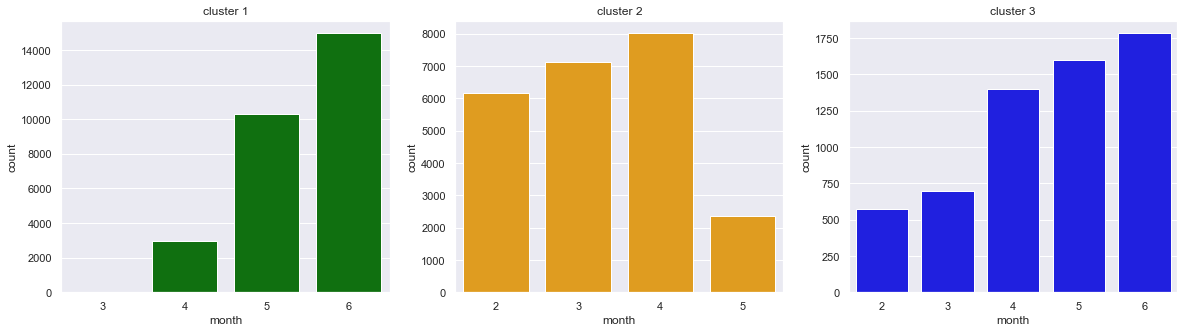

In [42]:
plot_hist_months("Bremen", X_date_copy, Y_date_copy, km_x, km_y)

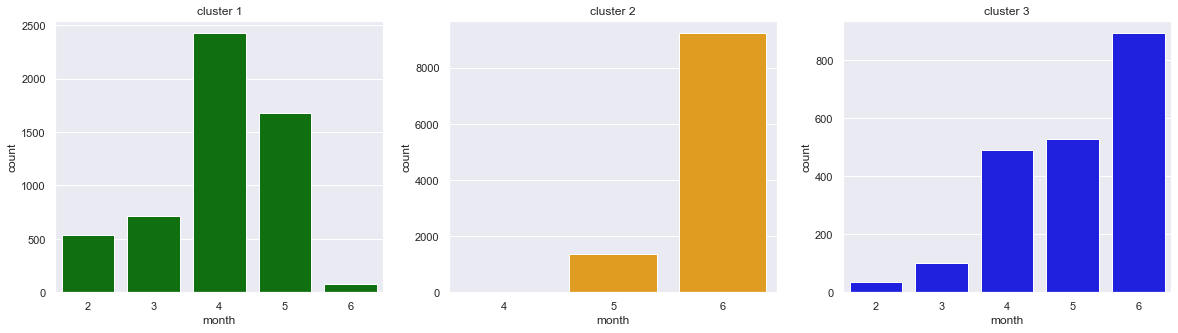

In [43]:
plot_hist_months("Düsseldorf", X_date_copy, Y_date_copy, km_x, km_y)

**seems as if the clusters are unevenly represented on the whole time axis, but only partly seem to reflect seasons**

### trying again without dates and temp

In [44]:
# generate is_weekday column for later use
X["dates"] = [pd.to_datetime(d) for d in X.datetime_start]
X["weekday"] = [dt.weekday() for dt in X.dates]
X["is_weekday"] = X["weekday"] <=4
X=X.drop(["dates", "weekday"],axis=1)

Y["dates"] = [pd.to_datetime(d) for d in Y.datetime_start]
Y["weekday"] = [dt.weekday() for dt in Y.dates]
Y["is_weekday"] = Y["weekday"] <=4
Y=Y.drop(["dates", "weekday"],axis=1)

In [45]:
kmeans = KMeans(n_clusters=3)
x_new = X.drop(["datetime_start", "datetime_end", "temp"], axis=1)
y_new = Y.drop(["datetime_start", "datetime_end", "temp"], axis=1) 
km_x1 = kmeans.fit_predict(x_new)
km_y1 = kmeans.fit_predict(y_new)

In [55]:
y_new

,orig_lat,orig_lng,dest_lat,dest_lng,hour,distance,trip_duration_hours,avg_speed,wind,rain,distance_from_center_start,distance_from_center_end,is_weekday
0,51.218927,6.765862,51.240644,6.781982,15,2.662958,0.283333,9.398675,5.0,0.0,1.036326,1.640146,True
1,51.213766,6.751624,51.223056,6.779230,15,2.182598,0.383333,5.693734,5.6,0.0,2.118449,0.564271,True
2,51.229671,6.797855,51.218527,6.794867,13,1.256486,1.333333,0.942365,3.5,0.0,1.705766,1.733373,True
3,51.218527,6.794867,51.252515,6.782041,6,3.883302,0.366667,10.590823,0.5,0.0,1.733373,2.914828,True
4,51.252515,6.782041,51.242592,6.782100,14,1.103349,0.200000,5.516746,1.7,0.0,2.914828,1.847300,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18033,51.227590,6.772325,51.226898,6.771832,20,0.084326,0.700000,0.120466,3.3,0.0,0.133362,0.136410,False
18034,51.226898,6.771832,51.229461,6.777001,10,0.459157,0.883333,0.519800,1.9,0.0,0.136410,0.369681,True
18035,51.229461,6.777001,51.229505,6.776754,20,0.017920,0.066667,0.268800,3.2,0.0,0.369681,0.363504,True
18036,51.237900,6.789368,51.222489,6.813165,12,2.383758,0.316667,7.527656,2.9,0.0,1.642048,2.784130,True


C:\Users\andre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


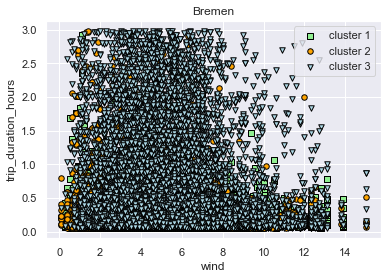

In [46]:
plot_clusters_city("Bremen", "wind", "trip_duration_hours", x_new, y_new, km_x1, km_y1)

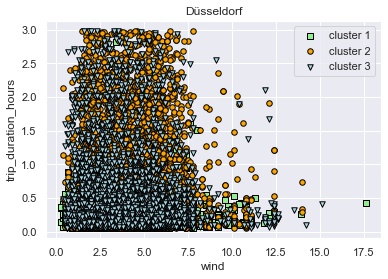

In [96]:
plot_clusters_city("Düsseldorf", "wind", "trip_duration_hours", x_new, y_new, km_x1, km_y1)

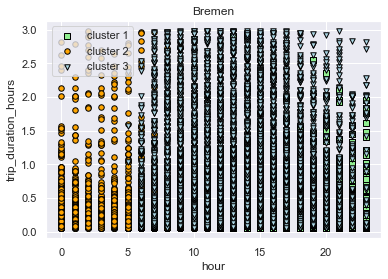

In [47]:
plot_clusters_city("Bremen", "hour", "trip_duration_hours", x_new, y_new, km_x1, km_y1)

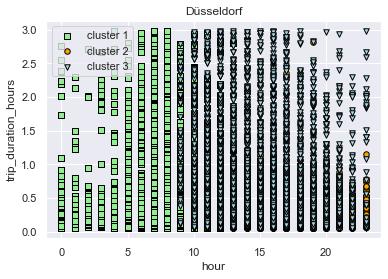

In [48]:
plot_clusters_city("Düsseldorf", "hour", "trip_duration_hours", x_new, y_new, km_x1, km_y1)

##### there seems to be a clear division by hours

### Now we go into further detail and analyze each cluster to find the most appropriate label (if possible)

In [49]:
cluster1_br = x_new[km_x1==0]
cluster2_br = x_new[km_x1==1]
cluster3_br = x_new[km_x1==2]
cluster1_du = y_new[km_y1==0]
cluster2_du = y_new[km_y1==1]
cluster3_du = y_new[km_y1==2]

In [50]:
cluster1_br.head()

,orig_lat,orig_lng,dest_lat,dest_lng,hour,distance,trip_duration_hours,avg_speed,wind,rain,distance_from_center_start,distance_from_center_end,is_weekday
0,53.078923,8.884911,53.078711,8.899906,17,1.001900,0.216667,4.624155,2.0,0.0,5.486415,6.488083,False
2,53.078923,8.884911,53.074731,8.876003,22,0.755886,0.133333,5.669146,4.4,0.0,5.486415,4.913475,True
5,53.078923,8.884911,53.073298,8.794316,13,6.084054,0.816667,7.449862,3.2,0.0,5.486415,0.840472,True
6,53.073529,8.794269,53.077716,8.897971,15,6.943062,0.816667,8.501708,4.3,0.0,0.823776,6.360221,True
8,53.127139,8.898528,53.113707,9.077220,13,12.017662,1.183333,10.155771,1.1,0.0,8.345218,18.728986,False


##### since we want to differentiate between commuters and other groups, we now look at the distributions for each cluster on weekdays and weekends


In [51]:
def plot_hist(dat1, dat2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    sns.distplot(dat1.loc[dat1["is_weekday"] == True]["hour"], ax=ax1)
    sns.distplot(dat1.loc[dat1["is_weekday"] == False]["hour"], ax=ax2)

    ax1.set_title(f'{label1}, weekday')
    ax1.set_ylim(0, 0.5)
    ax2.set_title(f'{label1}, weekend')
    ax2.set_ylim(0, 0.5)
    
    fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    sns.distplot(dat2.loc[dat2["is_weekday"] == True]["hour"], color='g', ax=ax3)
    sns.distplot(dat2.loc[dat2["is_weekday"] == False]["hour"], color='g', ax=ax4)

    ax3.set_title(f'{label2}, weekday')
    ax3.set_ylim(0, 0.5)
    ax4.set_title(f'{label2}, weekend')
    ax4.set_ylim(0, 0.5)

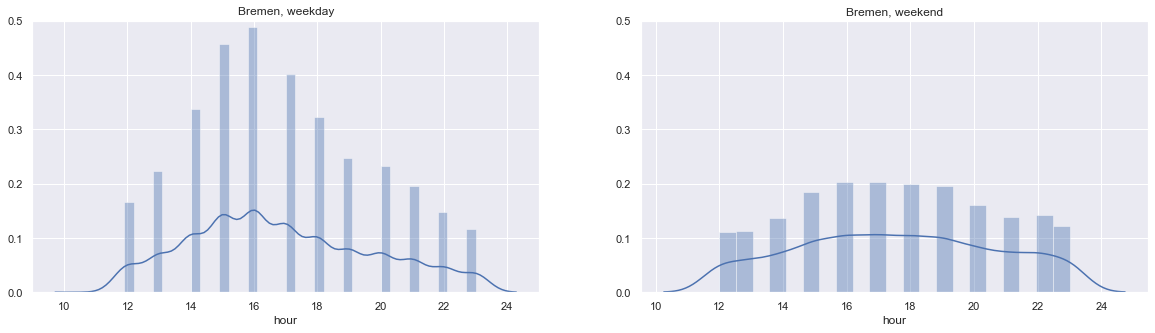

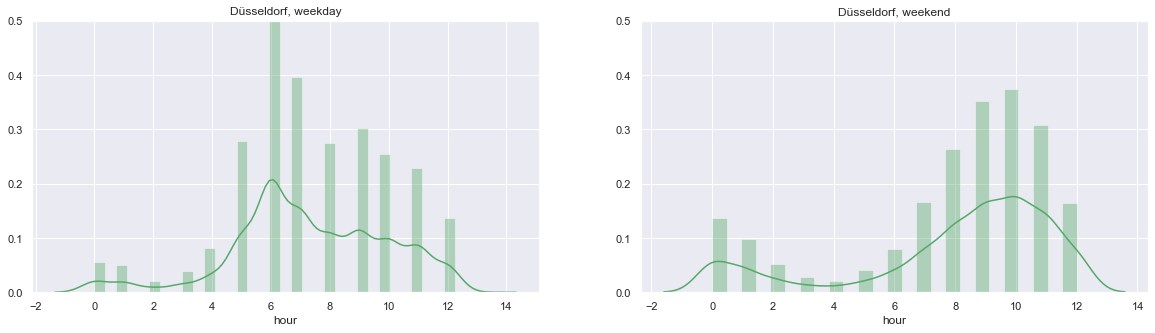

In [52]:
plot_hist(cluster1_br, cluster1_du, "Bremen", "Düsseldorf")

##### cluster 1 from bremen
- on weekdays shows a noon/afternoon spike of trips, on weekdays there is a higher number of trips on average
- on weekends shows a spike of trips around early noon (12:00)

##### cluster 1 from Düsseldorf
- on weekdays shows a more distinct spike around late afternoon (16:00, rush hour) 
- on weekends shows a more even distribution

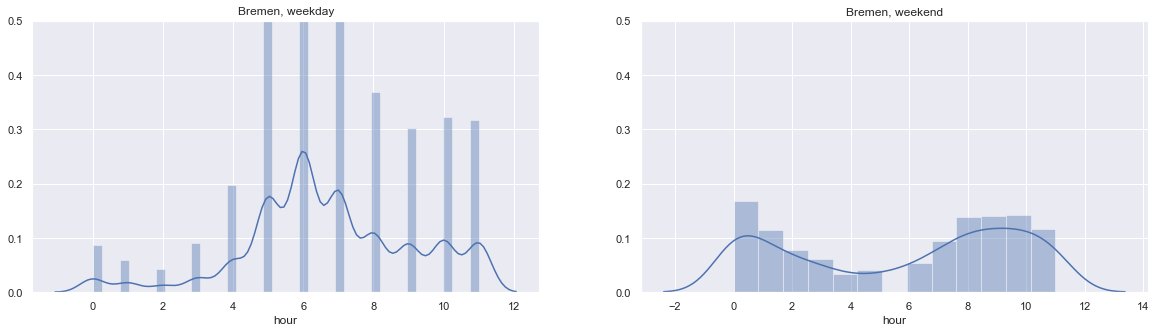

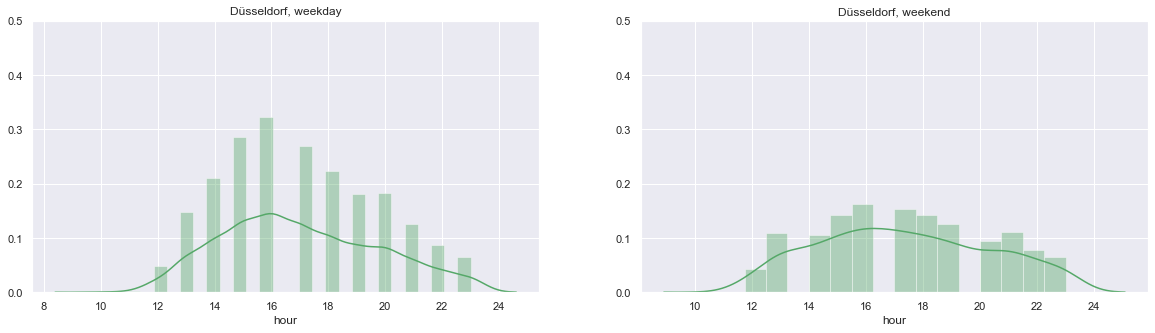

In [53]:
plot_hist(cluster2_br, cluster2_du, "Bremen", "Düsseldorf")

##### cluster 2 from bremen
- on weekdays shows a significant spike of trips in the early morning hours (around 05:00-07:00, morning rush hour)
- on weekends shows the lowest amount of trips in these hours with higher amount of trips at night and early noon


##### cluster 2 from düsseldorf
- on weekdays shows a very even distribution with its maximum in the afternoon (15:00, 16:00) 
- on weekends shows a spike for the trip numbers in the noon (13:00)

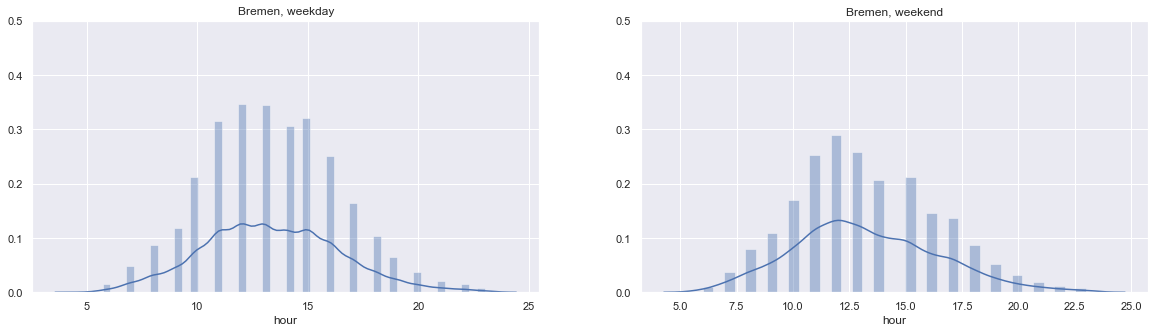

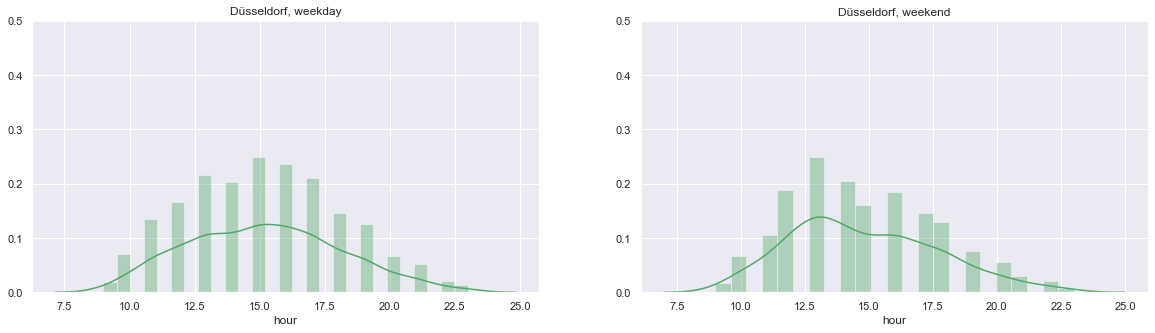

In [54]:
plot_hist(cluster3_br, cluster3_du, "Bremen", "Düsseldorf")

##### cluster 3 from bremen
- on weekdays shows a very clear spike of trips in the afternoon (15:00, 16:00)
- on weekends, it is more evenly distributed

##### cluster 3 from düsseldorf
- on weekdays shows a very distinct spike of trips around the early morning hours (05:00, 07:00)
- on weekends shows a lower amount of trips in these hours with higher amount of trips at early noon (10:00)

# Final results:

- wind, hour, temperature, weekday have a significant impact on the clustering, since the distributions of the clusters differ strongly on these features
- especially hour should be included in the set of features, since the clusters captured different distributions of trip numbers per hour
- temperature potentially has a very strong impact on the clusters and moreso maybe a very strong impact on the number of rentals